This is notebook is a reproduction of the Random Walk policy evaluation example of David Silver's class on Reinforcement Learning, lecture 4:

http://www0.cs.ucl.ac.uk/staff/d.silver/web/Teaching_files/MC-TD.pdf

https://www.youtube.com/watch?v=PnHCvfgC_ZA&list=PL5X3mDkKaJrL42i_jhE4N-p6E2Ol62Ofa&index=4

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import random

The example MDP is a linear chain with 10 steps with equal probality to move right or left.
Left exit has 0 reward while right exit has 1.

In [15]:
class LinearChainProcess(object):

    def __init__(self, chain_length=10, left_reward=0, righ_reward=1,
                 verbose=False, rng_seed=None):
        self.chain_length = 10
        self.left_reward = left_reward
        self.righ_reward = righ_reward
        self.rng = random.Random(rng_seed)
    
    def run_episode(self):
        position = self.rng.randrange(self.chain_length)
        while True:
            # flip an unbiased coin
            action = 'left' if random.randrange(2) else 'right'
            if action == 'left':
                new_position = position - 1
                if position == 0:
                    yield position, new_position, action, self.left_reward
                    raise StopIteration  # end of episode
                else:
                    yield position, new_position, action, 0
            else:
                new_position = position + 1  # move right
                if position == self.chain_length - 1:
                    yield position, new_position, action, self.righ_reward
                    raise StopIteration  # end of episode
                else:
                    yield position, new_position, action, 0
            position = new_position  # move left


In [16]:
p = LinearChainProcess(rng_seed=None)

total_gain = 0
for position, new_position, action, reward in p.run_episode():
    print(position, action, reward)
    total_gain += reward

print("total gain:", total_gain)

3 right 0
4 right 0
5 left 0
4 right 0
5 left 0
4 right 0
5 left 0
4 left 0
3 left 0
2 right 0
3 right 0
4 right 0
5 right 0
6 right 0
7 left 0
6 right 0
7 left 0
6 right 0
7 right 0
8 right 0
9 right 1
total gain: 1


In [17]:
TRUE_VALUES = np.linspace(0.1, 0.9, 10)  # compute with dynamic programming

In [18]:
class BaseEvaluator(object):

    def __init__(self, process, alpha=0.1):
        self.process = process
        self.n_states = process.chain_length
        self.alpha = alpha
        self.reset_value_function()
    
    def label(self):
        return type(self).__name__ + " alpha=%f" % self.alpha
    
    def rmse(self, true_values=TRUE_VALUES):
        return np.sqrt(((true_values - self.v) ** 2).sum())
    
    def reset_value_function(self):
        self.v = np.ones(self.n_states, dtype=np.float64) * 0.5
        self.n_episodes = 0
    
class MonteCarloEvaluator(BaseEvaluator):
        
    def run(self, n_episodes=1):
        for episode in range(n_episodes):
            positions, rewards = [], []
            for position, _, action, reward in self.process.run_episode():
                positions.append(position)
                rewards.append(reward)
            gains = np.cumsum(rewards[::-1])[::-1]
            first_visit_gains = {}
            for i, position in enumerate(positions):
                first_visit_gains.setdefault(position, gains[i])
            for position, gain in first_visit_gains.items():
                old_v = self.v[position]
                self.v[position] += self.alpha * (gain - old_v)
            self.n_episodes += 1

In [19]:
def plot_evaluator(evaluator, target_episodes):
    target_episodes = sorted(target_episodes)
    for n_episodes in target_episodes:
        if n_episodes > evaluator.n_episodes:
            evaluator.run(n_episodes - evaluator.n_episodes)
        plt.plot(evaluator.v, label="%d episodes" % evaluator.n_episodes)
        yield evaluator.rmse()
    plt.legend(loc='best')
    plt.title("%s, alpha=%f" % (type(evaluator).__name__, evaluator.alpha))

In [20]:
convergence = []

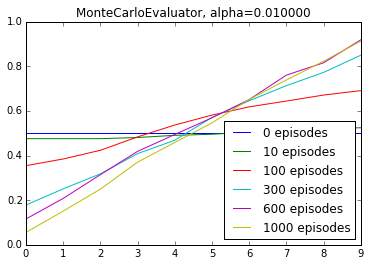

In [21]:
mce = MonteCarloEvaluator(p, alpha=0.01)
episodes_range = [0, 10, 100, 300, 600, 1000]
errors = list(plot_evaluator(mce, episodes_range))
convergence.append((mce.label(), errors, '^--'))

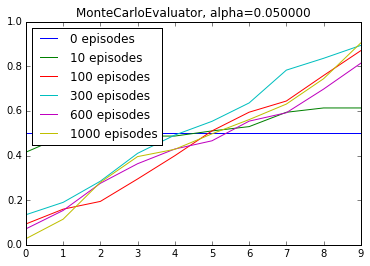

In [22]:
mce = MonteCarloEvaluator(p, alpha=0.05)
errors = list(plot_evaluator(mce, episodes_range))
convergence.append((mce.label(), errors, 'v--'))

In [23]:
class TimeDifferenceEvaluator(BaseEvaluator):
        
    def run(self, n_episodes=1):
        for episode in range(n_episodes):
            for pos, new_pos, action, reward in self.process.run_episode():
                prev_v = self.v[pos]
                if new_pos < 0 or new_pos >= self.n_states:
                    next_v = 0
                else:
                    next_v = self.v[new_pos]
                td_target = reward + next_v
                self.v[pos] += self.alpha * (td_target - prev_v)
            self.n_episodes += 1

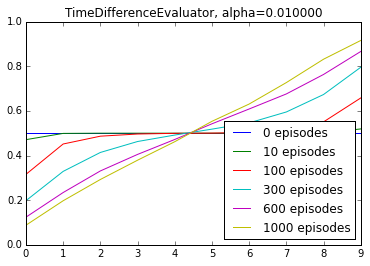

In [24]:
tde = TimeDifferenceEvaluator(p, alpha=0.01)
errors = list(plot_evaluator(tde, episodes_range))
convergence.append((tde.label(), errors, '^-'))

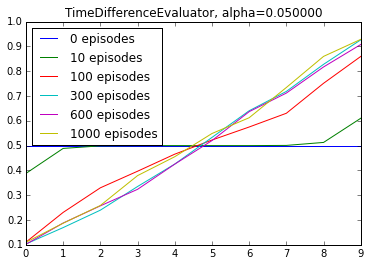

In [25]:
tde = TimeDifferenceEvaluator(p, alpha=0.05)
errors = list(plot_evaluator(tde, episodes_range))
convergence.append((tde.label(), errors, 'v-'))

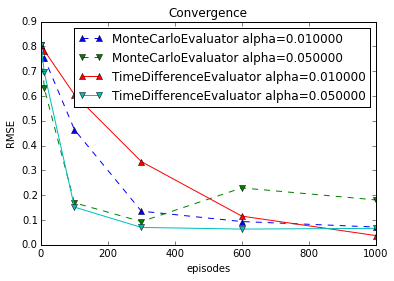

In [26]:
for label, errors, style in convergence:
    plt.plot(episodes_range, errors, style, label=label)
    
plt.xlabel('episodes')
plt.ylabel('RMSE')
plt.title("Convergence")
plt.legend(loc='best');